# Fitting the mean and variance of Praesepe.

In [735]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as sco
import scipy.misc as spm

plotpar = {'axes.labelsize': 40,
           'font.size': 30,
           'legend.fontsize': 20,
           'xtick.labelsize': 40,
           'ytick.labelsize': 40,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the Praesepe data.

In [711]:
pr = pd.read_csv("data/praesepe.csv")
m = pr.prot > 0
m &= np.log10(pr.bp[m] - pr.rp[m]) < max(np.log10(pr.bp[m] - pr.rp[m]))

logbprp = np.log10(pr.bp[m] - pr.rp[m])
logp = np.log10(pr.prot[m])
err = .434 * .1
logp_err = err * np.ones_like(logp)
log_age = np.ones(len(logp))*np.log10(650*1e6)

Add the Sun.

In [712]:
sun_age, sun_prot, sun_color = np.array([np.log10(4.56*1e9)]), np.array([np.log10(26)]), np.array([np.log10(.82)])
sun_err = np.array([.0001])

logbprp_sun = np.concatenate((logbprp, sun_color))
logp_sun = np.concatenate((logp, sun_prot))
log_age_sun = np.concatenate((log_age, sun_age))
logp_err_sun = np.concatenate((logp_err, sun_err))

<ErrorbarContainer object of 3 artists>

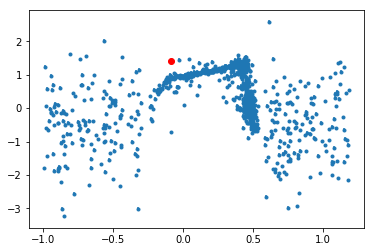

In [713]:
# Now augment the data with hot and cool stars.
nhot, ncool = 150, 150
logbprp_aug = np.concatenate((logbprp_sun, np.random.uniform(-1, -.3, nhot), np.random.uniform(.58, 1.2, ncool)))
logp_aug = np.concatenate((logp_sun, np.random.randn(nhot)*1 - .5, np.random.randn(ncool)*1 - .5))
log_age_aug = np.concatenate((log_age_sun, np.ones(nhot)*np.log10(650*1e6), np.ones(ncool)*np.log10(650*1e6)))
logp_err_aug = np.concatenate((logp_err_sun, np.ones(nhot)*err, np.ones(ncool)*err))

plt.errorbar(logbprp_aug, logp_aug, yerr=logp_err_aug, fmt=".")
plt.errorbar(sun_color, sun_prot, yerr=sun_err, fmt="ro")

In [772]:
def model(p, log_c, log_age):
    return np.polyval(p[:20], log_c) + p[20]*log_age

def variance(p, log_c, prot_err):
    return (prot_err + np.polyval(p[21:], log_c))**2

In [773]:
def lnlike(p, log_c, log_prot, log_age, prot_err):
    mod = model(p, log_c, log_age)
    var = variance(p, log_c, prot_err)
    return np.sum(-.5 * (mod - log_prot)**2/var - .5*np.log(2*np.pi*var))

def nll(p, log_c, log_prot, log_age, prot_err):
    mod = model(p, log_c, log_age)
    var = variance(p, log_c, prot_err)
    return np.sum((-.5 * (mod - log_prot)**2/var - .5*np.log(2*np.pi*var))*-1)

In [774]:
p0 = np.ones(24)
results = sco.minimize(nll, p0, args=(logbprp_aug, logp_aug, log_age_aug, logp_err_aug))
print(results.x)

[ 1.84609072e+02 -9.46718484e+01 -4.31717570e+02  8.46729321e+01
  8.54668045e+00  2.04505770e+02  6.50013760e+02 -1.48657318e+02
 -1.28921465e+02 -2.96402024e+02 -9.46190254e+02  3.79690571e+02
  9.87734344e+02 -1.51424518e+02 -3.68864845e+02  2.73928513e+01
  4.36406776e+01 -6.75060449e+00  8.30907478e-01 -5.42685375e+00
  7.23499436e-01  1.95043590e+00 -3.51825393e-01  1.49862010e-01]


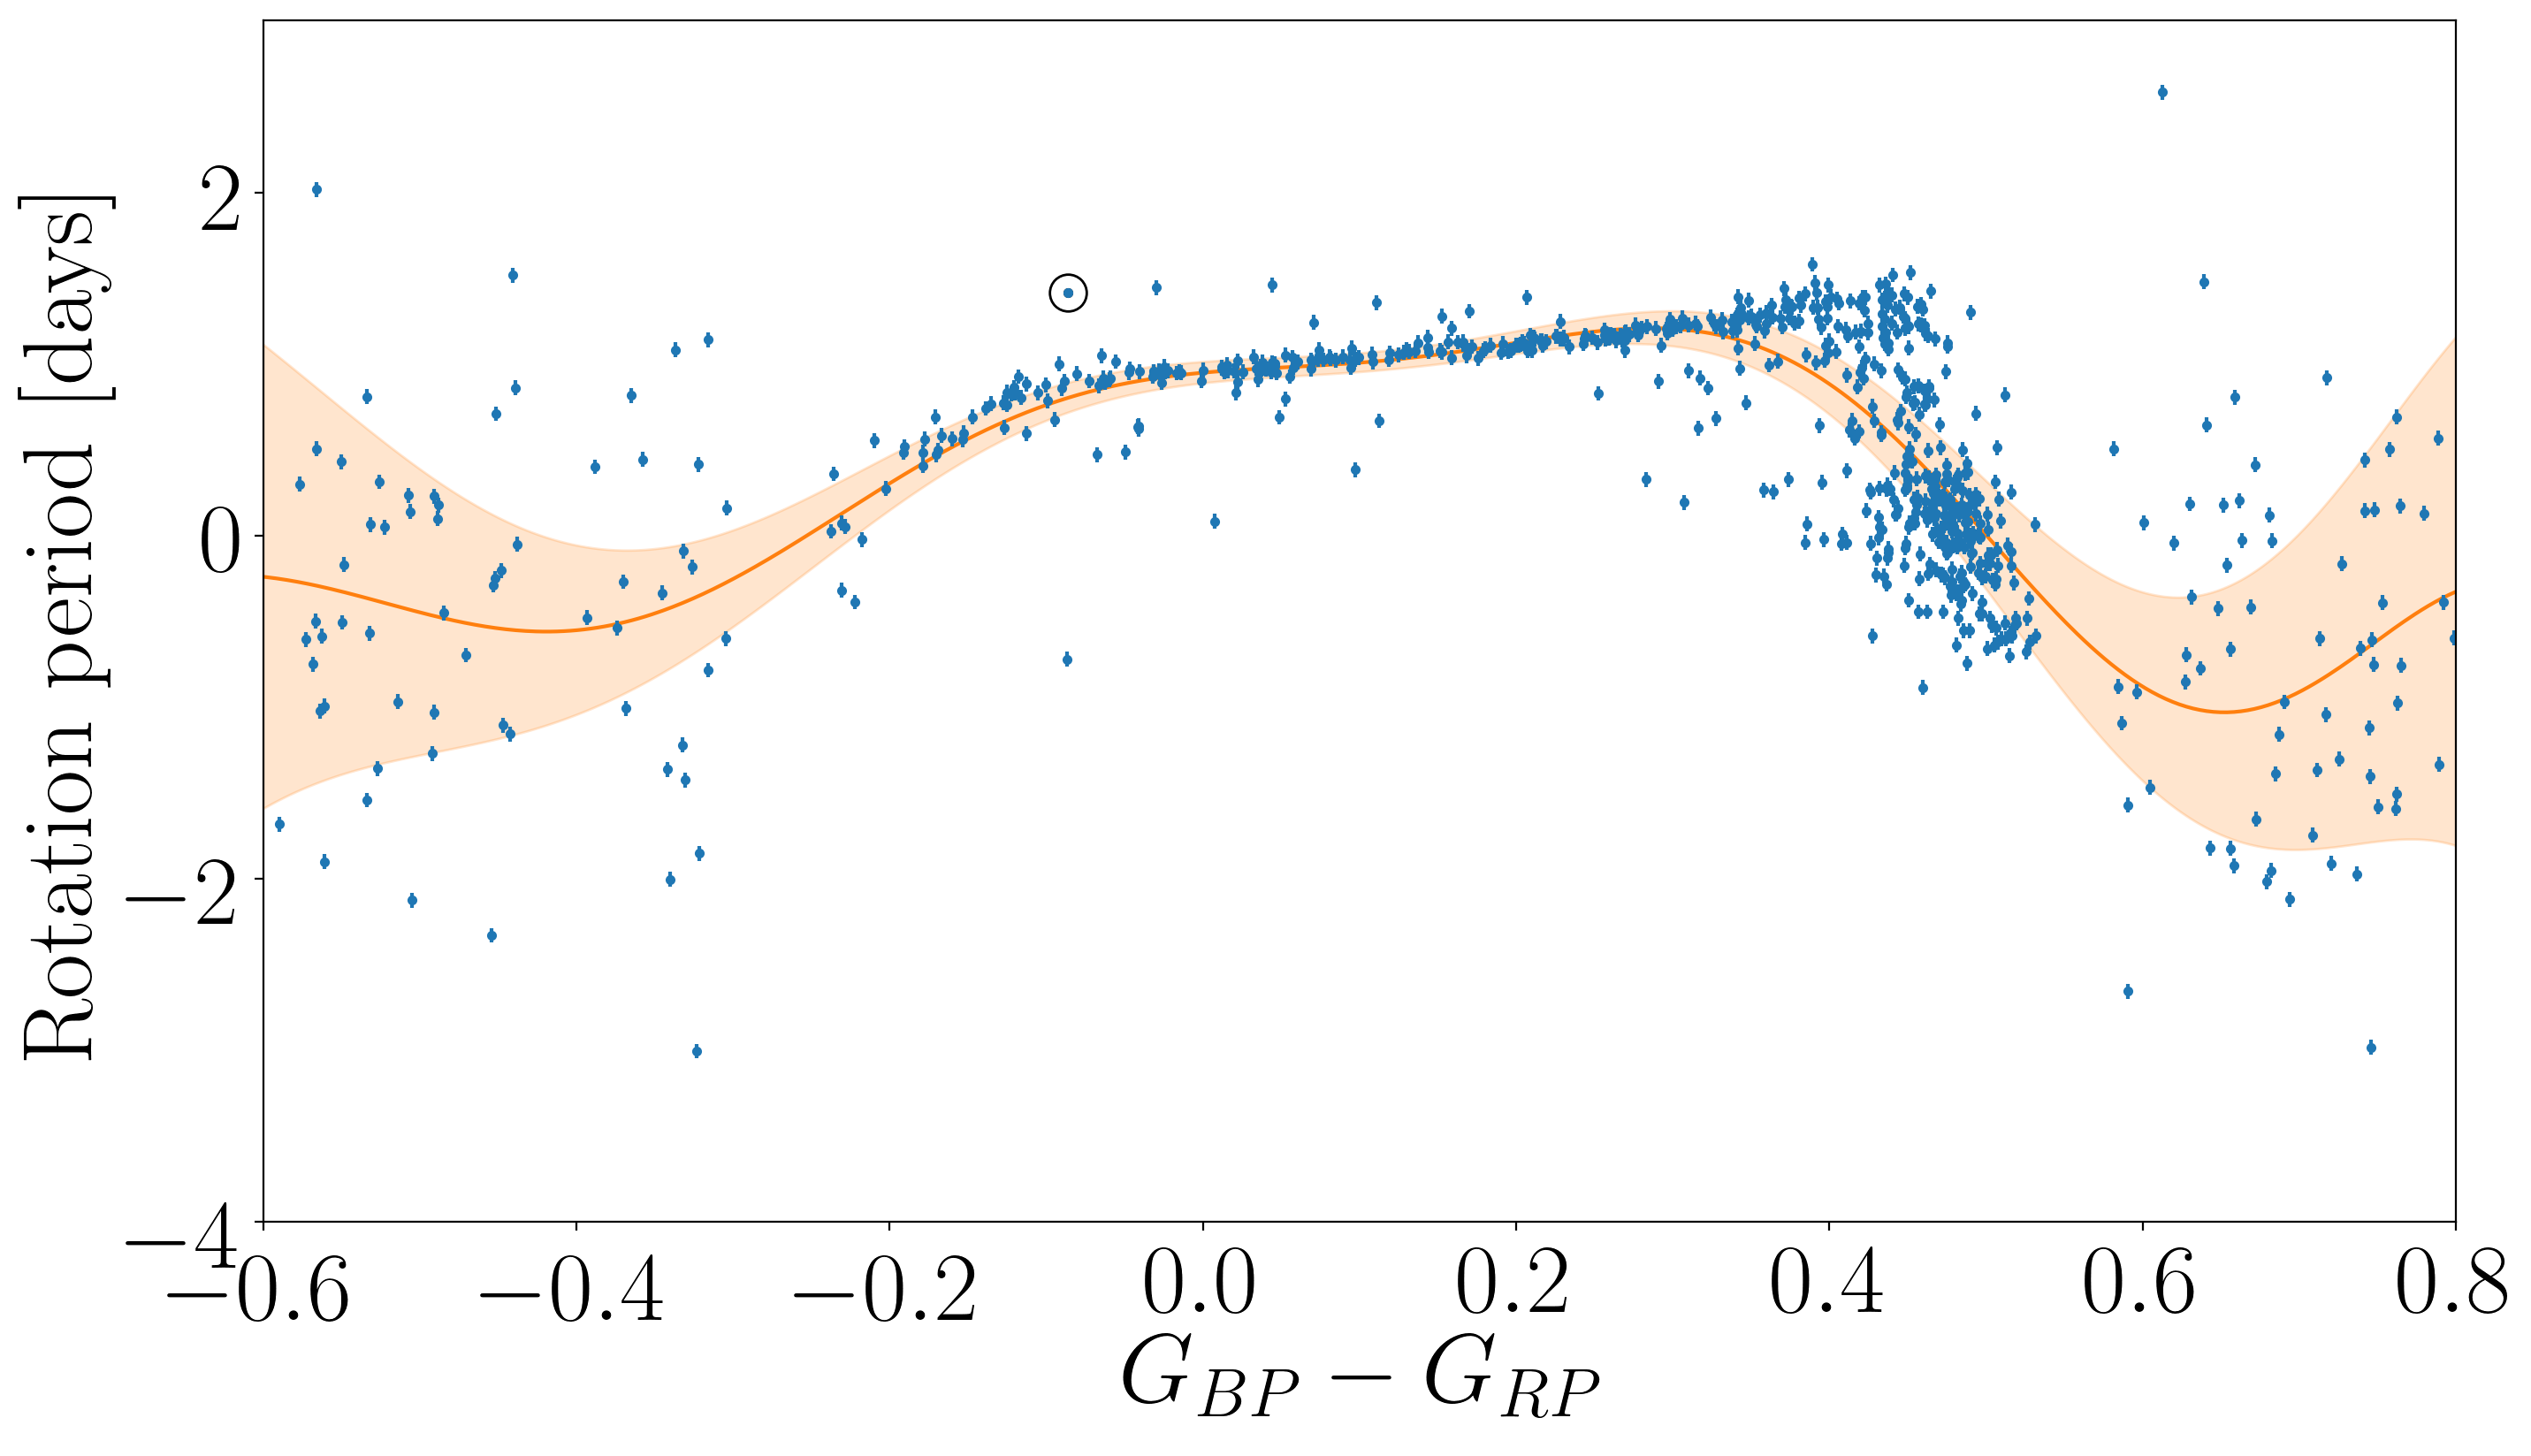

In [775]:
plt.figure(figsize=(16, 9), dpi=200)
plt.errorbar(logbprp_aug, logp_aug, yerr=logp_err_aug, fmt=".");
plt.plot(x, model(results.x, x, np.log10(650*1e6)), zorder=1)

plt.plot(sun_color, sun_prot, "wo", markeredgecolor="k", ms=15, zorder=2)
plt.plot(sun_color, sun_prot, ".k", zorder=2)

mean, var = model(results.x, x, np.log10(650*1e6)), variance(results.x, x, np.ones_like(x)*.1);
plt.fill_between(x, mean + var, mean - var, alpha=.2, color="C1", zorder=0);
plt.xlim(-.6, .8)
plt.ylim(-4, 3)
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$");

(-0.6, 0.8)

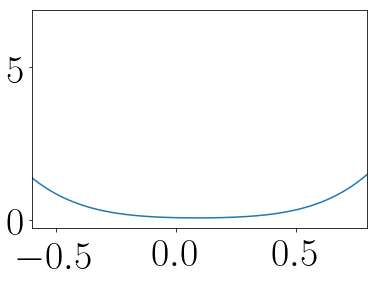

In [776]:
plt.plot(x, var)
plt.xlim(-.6, .8)

Now make up some data that allows you to have a smoothly increasing variance for EEP.

In [777]:
neep = 100
cut = 4.2
subgiant_eeps = np.random.uniform(cut, 6, neep)
eeps = np.concatenate((np.random.uniform(2, cut, len(logbprp)), subgiant_eeps))
eep_prot = np.concatenate((np.zeros(len(logp))+np.random.randn(len(logp))*.05, 
                           np.random.randn(neep)*(1.5*subgiant_eeps - cut)))  # This is invented

def eep_model(p, log_c):
    return np.zeros(len(log_c))

def eep_variance(p, log_c, logprot_err):
    return (logprot_err + np.polyval(p, log_c))**2
            
def eep_nll(p, log_c, logprot, logprot_err):
    mod = eep_model(p, log_c)
    var = eep_variance(p, log_c, logprot_err)
    return np.sum((-.5 * (mod - logprot)**2/var - .5*np.log(2*np.pi*var)))*-1

eep_p0 = 1e-2*np.ones(4)
yerr = err * np.ones_like(eep_prot)

[ 0.24748806 -2.03319899  5.47851595 -4.82244832]


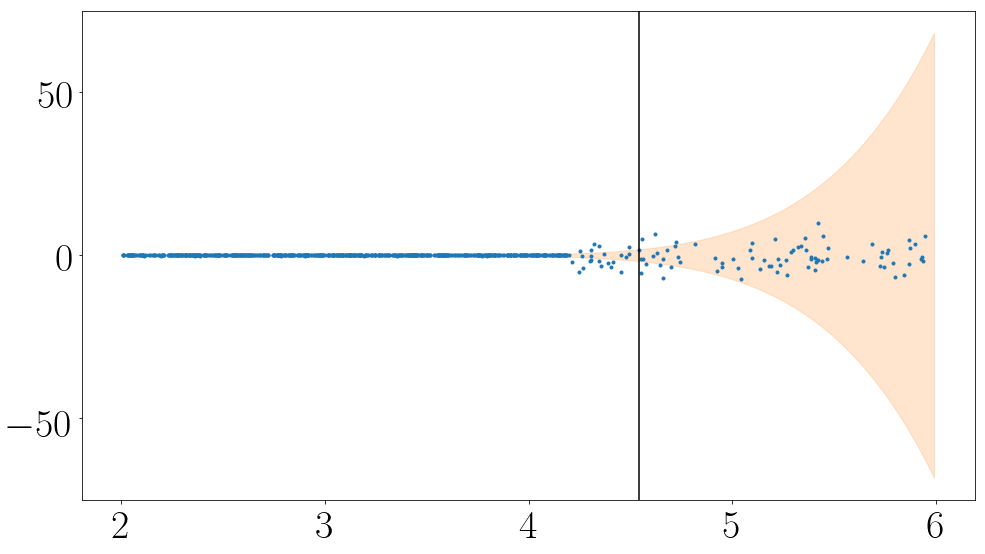

In [778]:
eep_results = sco.minimize(eep_nll, eep_p0, args=(eeps, eep_prot, yerr))
print(eep_results.x)

eep_mean = eep_model(eep_results.x, eep_x)
eep_var = eep_variance(eep_results.x, eep_x, err)

plt.figure(figsize=(16, 9))
plt.plot(eeps, eep_prot, ".")
plt.fill_between(eep_x, eep_mean + eep_var, eep_mean - eep_var, alpha=.2, color="C1");
plt.axvline(4.54, color="k")

(0, 60)

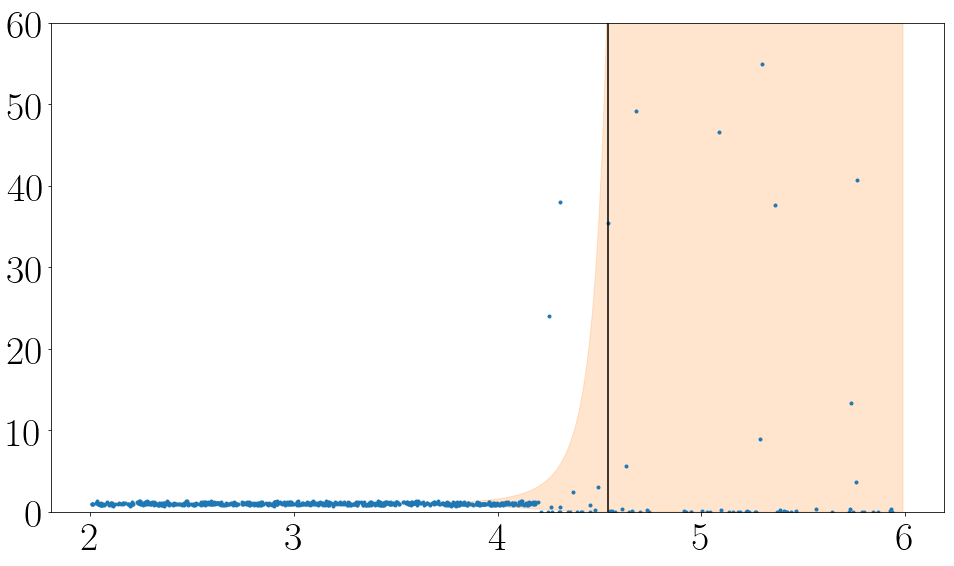

In [779]:
plt.figure(figsize=(16, 9))
plt.plot(eeps, 10**eep_prot, ".")
plt.fill_between(eep_x, 10**(eep_mean + eep_var), 10**(eep_mean - eep_var), alpha=.2, color="C1");
plt.axvline(4.54, color="k")
plt.ylim(0, 60)

Simulate stars from this model to check that things look reasonable.

In [783]:
best_fit = np.concatenate((results.x, eep_results.x))

def total_variance(p, log_c, eep, logp_err):
    z = eep/100.
    return (logp_err + np.polyval(p[21:24], log_c) + np.polyval(p[24:], eep))**2

def generative_model(p, log_c, log_age, eep, logp_err):
    z = eep/100.
    mean = model(p, log_c, log_age)
    var = total_variance(p, log_c, z, logp_err)
    return mean + np.random.randn(len(log_c))*var

# def gyro_model(log10_age, log_c, params):
#     age_gyr = (10**log10_age)*1e-9
#     log_age_gyr = np.log10(age_gyr)
#     return np.polyval(params[:20], log_c) + params[21]*log10_age
print(results.x[20])
print(results.x)

0.7234994356347152
[ 1.84609072e+02 -9.46718484e+01 -4.31717570e+02  8.46729321e+01
  8.54668045e+00  2.04505770e+02  6.50013760e+02 -1.48657318e+02
 -1.28921465e+02 -2.96402024e+02 -9.46190254e+02  3.79690571e+02
  9.87734344e+02 -1.51424518e+02 -3.68864845e+02  2.73928513e+01
  4.36406776e+01 -6.75060449e+00  8.30907478e-01 -5.42685375e+00
  7.23499436e-01  1.95043590e+00 -3.51825393e-01  1.49862010e-01]


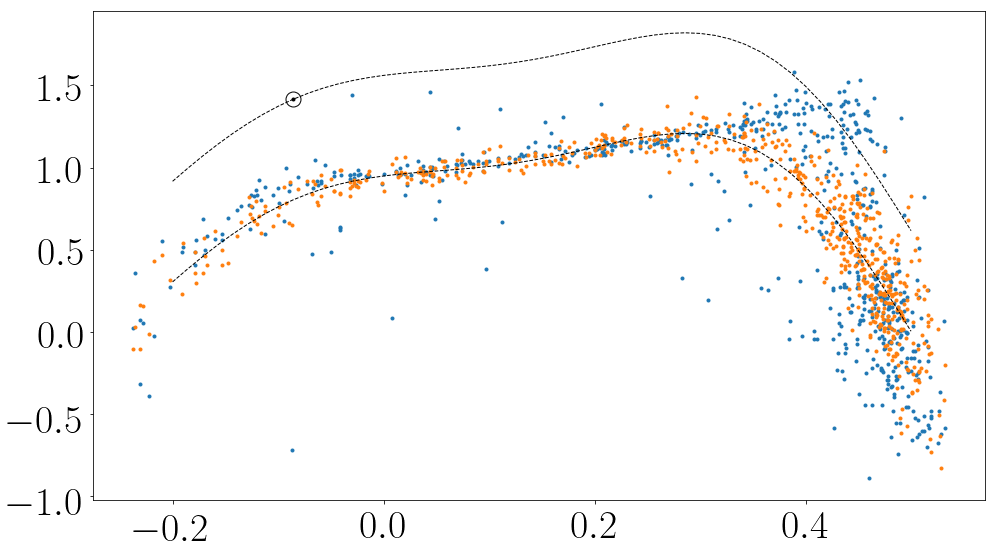

In [786]:
plt.figure(figsize=(16, 9))
plt.plot(logbprp, logp, ".")
dwarfs = generative_model(best_fit, logbprp, np.log10(650*1e6), np.ones_like(logbprp)*250, logp_err)
plt.plot(logbprp, dwarfs, ".")
plt.plot(np.linspace(-.2, .5), model(best_fit, np.linspace(-.2, .5), np.log10(650*1e6)),
         color="k", ls="--", lw=1)

plt.plot(sun_color, sun_prot, "wo", markeredgecolor="k", ms=15, zorder=2)
plt.plot(sun_color, sun_prot, ".k", zorder=2)
plt.plot(np.linspace(-.2, .5), model(best_fit, np.linspace(-.2, .5), np.log10(4.56*1e9)),
         color="k", ls="--", lw=1)

Now add the weakened magnetic braking.